In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, ADAM # Rotosolve or rotoselect?
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from typing import List, Tuple

algorithm_globals.random_seed = 12345

In [2]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [3]:
images, labels = generate_dataset(100)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

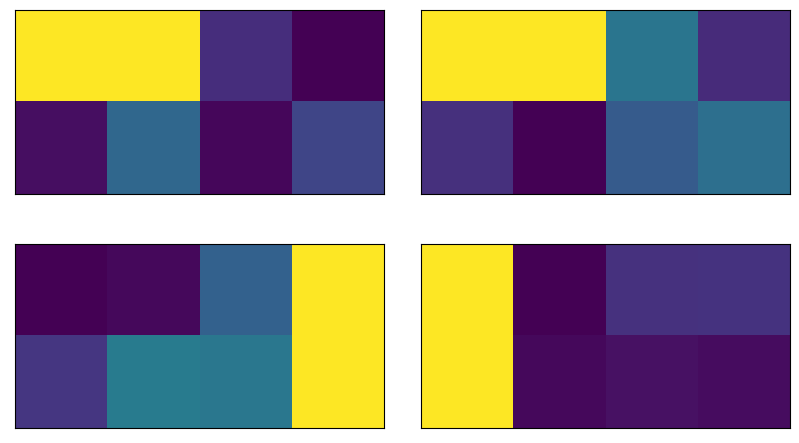

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

/Users/filipmazurek/miniconda3/envs/azure/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


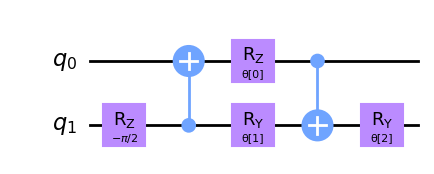

In [5]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

/Users/filipmazurek/miniconda3/envs/azure/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


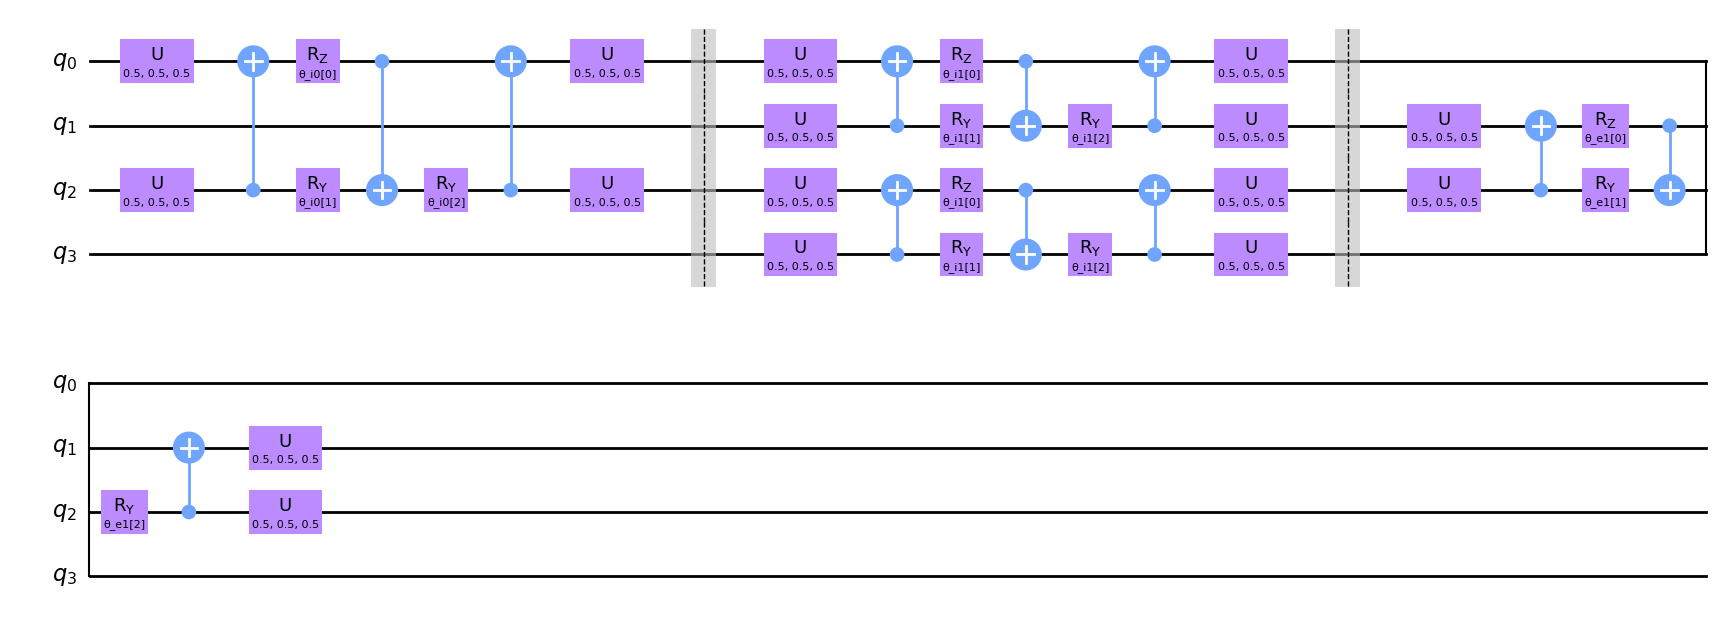

In [6]:
def isometry(circ: QuantumCircuit, l_Q: List[int], param_prefix: str) -> None:
    """ Adds isometry circuit by modifying input circuit. """
    params = ParameterVector(param_prefix, length=3)
    for i in range(0, len(l_Q), 2):
        circ.u(1/2, 1/2, 1/2, l_Q[i])
        circ.u(1/2, 1/2, 1/2, l_Q[i+1])
        circ.cx(l_Q[i+1], l_Q[i])
        circ.rz(params[0], l_Q[i])
        circ.ry(params[1], l_Q[i+1])
        circ.cx(l_Q[i], l_Q[i+1])
        circ.ry(params[2], l_Q[i+1])
        circ.cx(l_Q[i+1], l_Q[i])
        circ.u(1/2, 1/2, 1/2, l_Q[i])
        circ.u(1/2, 1/2, 1/2, l_Q[i+1])

def entangler(circ: QuantumCircuit, l_Q: List[int], param_prefix: str) -> None:
    """ Adds entangler circuit by modifying input circuit. """
    params = ParameterVector(param_prefix, length=3)
    for i in range(0, len(l_Q)-2, 2): 
        circ.u(1/2, 1/2, 1/2, l_Q[i+1])
        circ.u(1/2, 1/2, 1/2, l_Q[i+2])
        circ.cx(l_Q[i+2], l_Q[i+1])
        circ.rz(params[0], l_Q[i+1])
        circ.ry(params[1], l_Q[i+2])
        circ.cx(l_Q[i+1], l_Q[i+2])
        circ.ry(params[2], l_Q[i+2])
        circ.cx(l_Q[i+2], l_Q[i+1])
        circ.u(1/2, 1/2, 1/2, l_Q[i+1])
        circ.u(1/2, 1/2, 1/2, l_Q[i+2])

def qMERA_circuit(depth: int) -> QuantumCircuit:
    """ Given a depth, returns a Multiscale Entangelemnt Renormalization Ansatz circuit."""
    n_qubits = 2**depth
    circuit = QuantumCircuit(n_qubits)
    for j in range(depth):
        list_qb: List[int] = [i_nq for i_nq in range(0, n_qubits, n_qubits//(2**(j+1)))]    
        isometry(circuit, list_qb, f"θ_i{j}")
        circuit.barrier()
        entangler(circuit, list_qb, f"θ_e{j}")
     
    #circuit.measure_all()
    return circuit

c = qMERA_circuit(2)
c.draw('mpl')

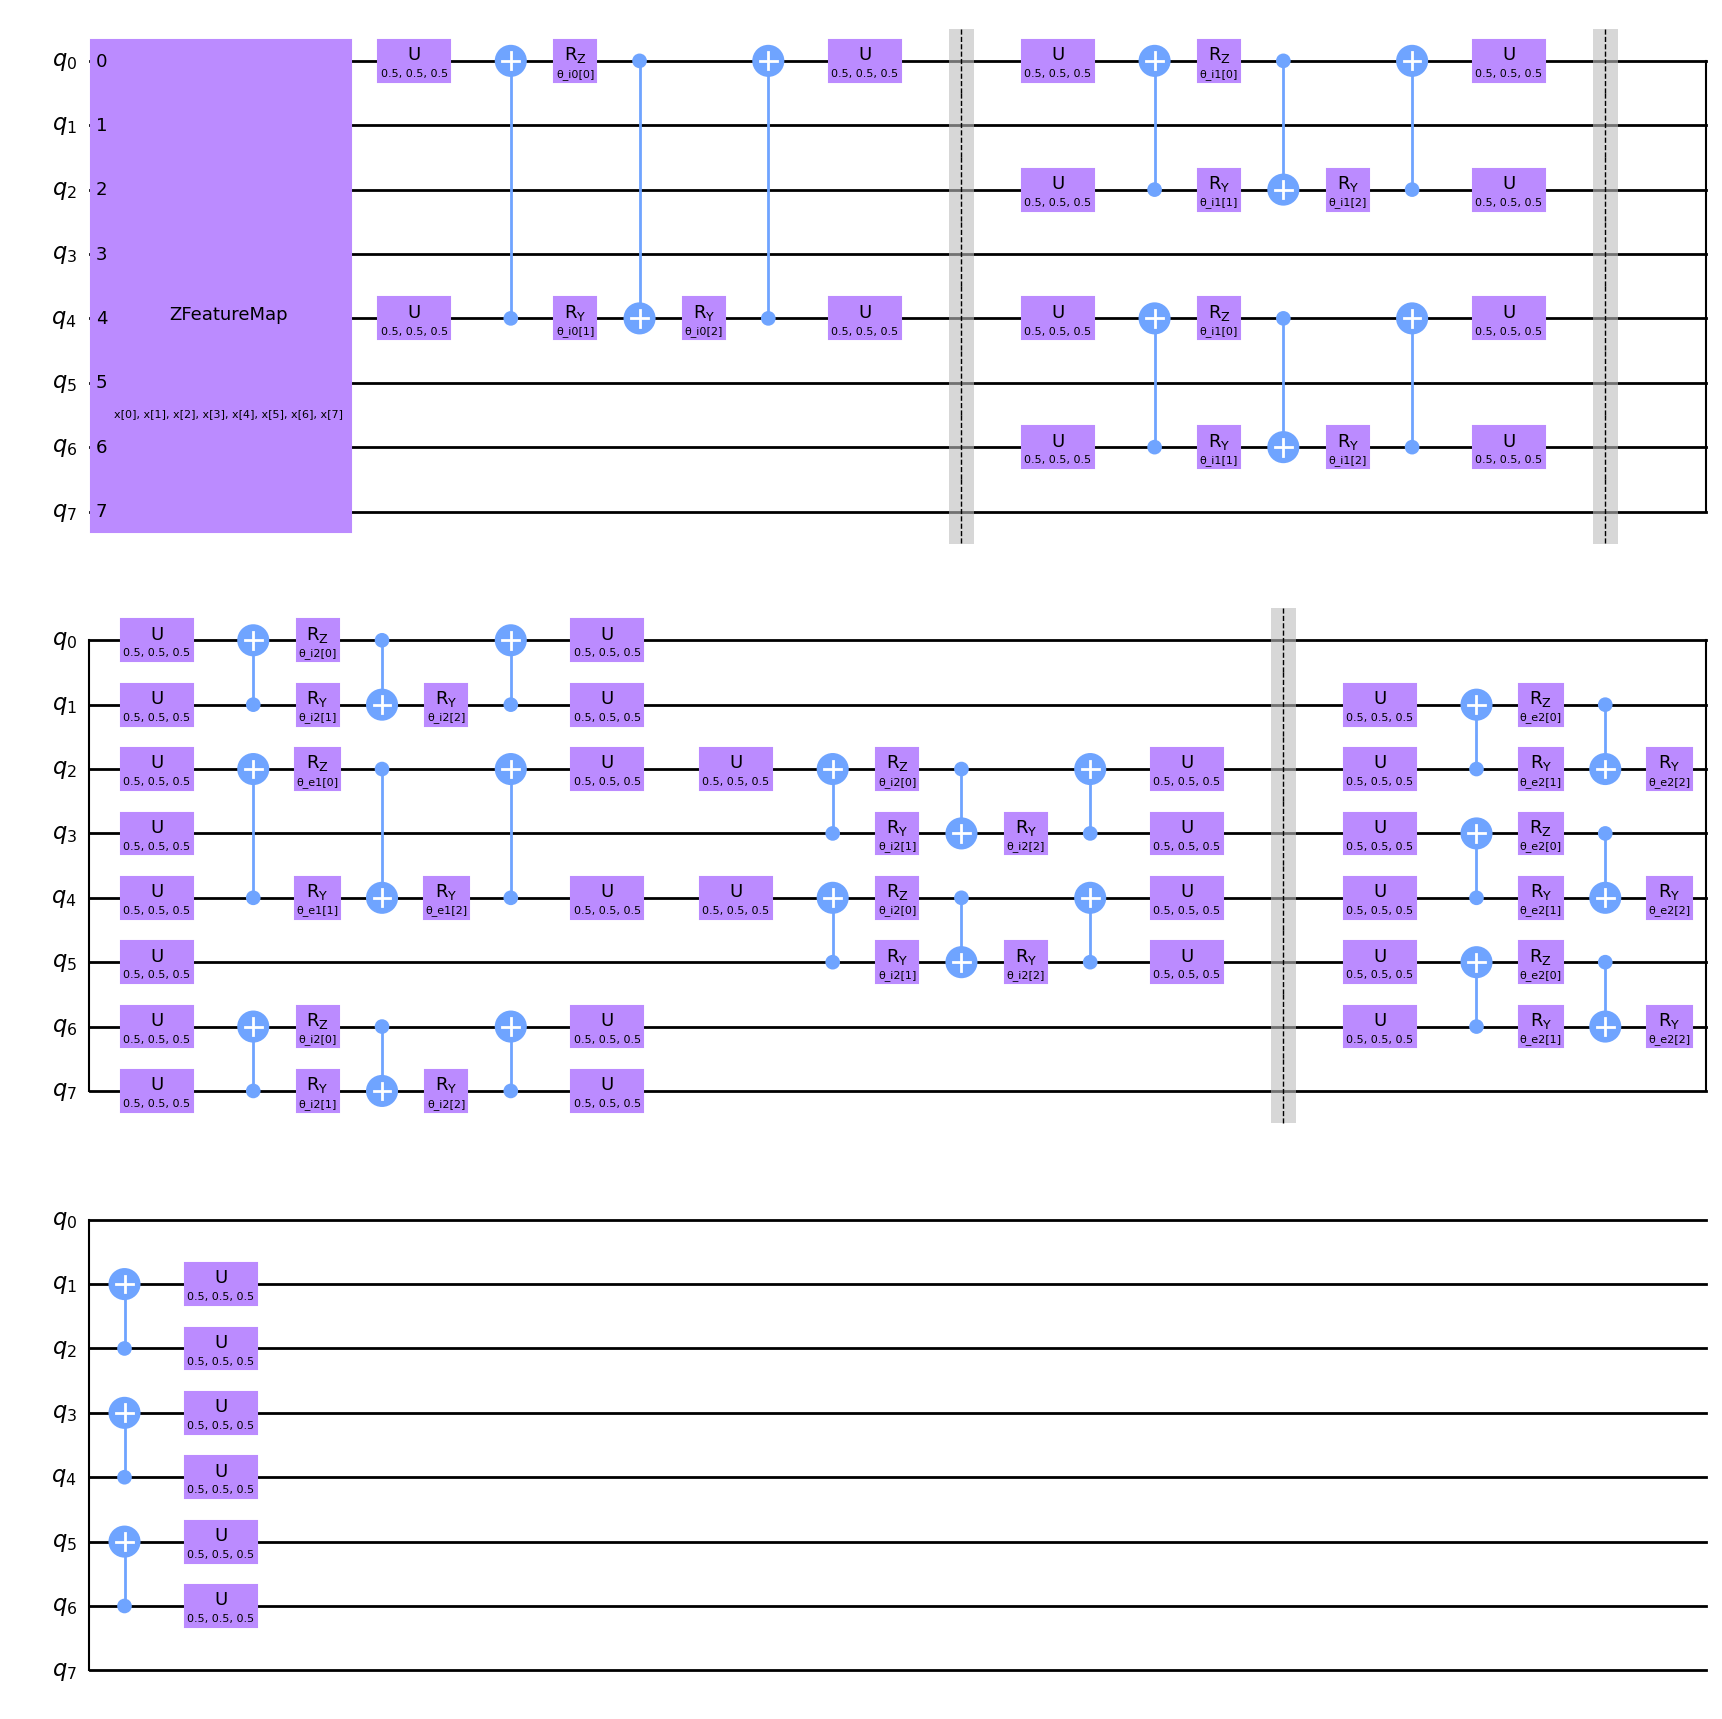

In [7]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

MERA = qMERA_circuit(3)

ansatz.compose(MERA,inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

circuit.draw("mpl")

In [8]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=np.zeros([15,]),
)

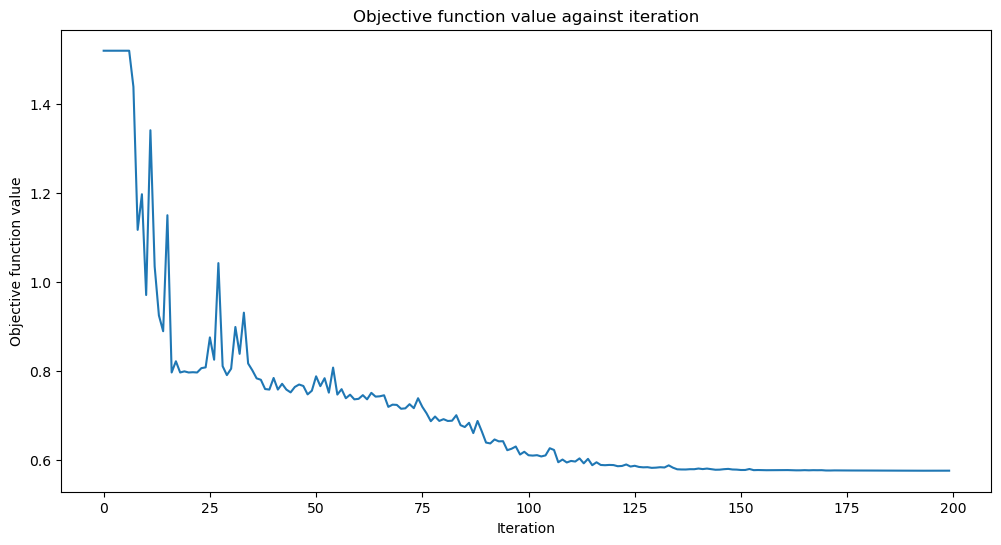

Accuracy from the train data : 81.43%


In [9]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")